In [1]:
import pandas as pd
from src.get_data import get_coinmetrics_data, get_binance_data
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
pairs = ['ETHUSDT']
binance_data = get_binance_data(pairs)

In [3]:
coinmetrics_data = pd.read_parquet('coinmrkets_data.parquet')

In [4]:
types = coinmetrics_data.set_index(['time','asset']).dtypes
get_ride_of_these_columns = list(types[types=='object'].index)
coinmetrics_data = coinmetrics_data.drop(columns=get_ride_of_these_columns)
coinmetrics_data = coinmetrics_data.set_index(['time','asset']).pct_change()

In [5]:
coinmetrics_data = coinmetrics_data[coinmetrics_data.index.get_level_values(1)=='eth'].pct_change()


In [6]:
translate_cm_to_binance = {
    'eth':'ETHUSDT',
    'btc':'BTCUSDT',
    'xrp':'XRPUSDT'}
fees_free_pairs = {
    'ETH' :'FDUSD',
    'BTC':'FDUSD',
    'XRP':'FDUSD'
}
translate_binance_to_cm = {
    'ETHUSDT':'eth',
    'BTCUSDT':'btc',
    'XRPUSDT':'xrp'}


In [7]:
close = binance_data.pivot_table(index='dateTime',columns='ticker',values='close')
returns = close.pct_change()
target = returns.shift(-1)
vols = returns.rolling(20).std()
returns = returns.unstack()
returns.name = 'returns'
vols = vols.unstack()
vols.name = 'vols_20D'
target = target.unstack()
target.name = 'target'
binance_data = pd.concat([returns,vols,target],axis=1).reset_index()
binance_data['asset'] =binance_data['ticker'] 

In [8]:
binance_data

,ticker,dateTime,returns,vols_20D,target,asset
0,ETHUSDT,2019-11-27,NaN,NaN,-0.013375,ETHUSDT
1,ETHUSDT,2019-11-28,-0.013375,NaN,0.026116,ETHUSDT
2,ETHUSDT,2019-11-29,0.026116,NaN,-0.019623,ETHUSDT
3,ETHUSDT,2019-11-30,-0.019623,NaN,-0.004822,ETHUSDT
4,ETHUSDT,2019-12-01,-0.004822,NaN,-0.013674,ETHUSDT
...,...,...,...,...,...,...
1526,ETHUSDT,2024-01-31,-0.025598,0.024423,0.009347,ETHUSDT
1527,ETHUSDT,2024-02-01,0.009347,0.023612,0.002023,ETHUSDT
1528,ETHUSDT,2024-02-02,0.002023,0.022860,-0.005446,ETHUSDT
1529,ETHUSDT,2024-02-03,-0.005446,0.021318,0.002257,ETHUSDT


In [9]:
binance_data['asset'] =binance_data['ticker'].map(translate_binance_to_cm)
binance_data['time'] = binance_data['dateTime'].dt.tz_localize('UTC')

In [10]:
all_data = coinmetrics_data.merge(binance_data, how='inner',on=['asset','time']).iloc[:-len(pairs),:]
all_data = all_data[all_data['returns'].notna()].set_index(['time','asset','ticker','dateTime'])

In [11]:
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data = all_data.fillna(-10000)

In [12]:
proption = 0.8
nb_obs = len(all_data.index.get_level_values(0).unique())
cut_off = all_data.index.get_level_values(0).unique()[int(nb_obs*proption)]

In [13]:
#all_data = all_data[all_data.index.get_level_values(1)=='eth']

In [14]:
y = (all_data['target']>0).astype(int)
X = all_data.copy().drop(columns='target')
X_train, X_test = X.loc[:cut_off],  X.loc[cut_off:]
y_train, y_test = y.loc[:cut_off],  y.loc[cut_off:]

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [16]:

names = [

    "Neural Net",
    "AdaBoost",
]

classifiers = [

    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
   
]


In [17]:
cols = ['AdrActCnt',
 'AdrBalCnt',
 'AssetEODCompletionTime',
 'BlkCnt',
 'BlkSizeMeanByte',
 'CapAct1yrUSD',
 'CapMVRVCur',
 'CapMVRVFF',
 'CapMrktCurUSD',
 'CapMrktFFUSD',
 'CapRealUSD',
 'DiffLast',
 'DiffMean',
 'FeeByteMeanNtv',
 'FeeMeanNtv',
 'FeeMeanUSD',
 'FeeMedNtv',
 'FeeMedUSD',
 'FeeTotNtv',
 'FeeTotUSD',
 'FlowInExNtv',
 'FlowInExUSD',
 'FlowOutExNtv',
 'FlowOutExUSD',
 'FlowTfrFromExCnt',
 'GasLmtBlk',
 'GasLmtBlkMean',
 'GasLmtTx',
 'GasLmtTxMean',
 'GasUsedTx',
 'GasUsedTxMean',
 'IssContNtv',
 'IssContPctAnn',
 'IssContPctDay',
 'IssContUSD',
 'IssTotNtv',
 'IssTotUSD',
 'NDF',
 'NVTAdj',
 'NVTAdjFF',
 'PriceBTC',
 'PriceUSD',
 'ReferenceRate',
 'ReferenceRateBTC',
 'ReferenceRateEUR',
 'ReferenceRateUSD',
 'RevNtv',
 'RevUSD',
 'SER',
 'SplyAct10yr',
 'SplyAct180d',
 'SplyAct1d',
 'SplyAct1yr',
 'SplyAct2yr',
 'SplyAct30d',
 'SplyAct3yr',
 'SplyAct4yr',
 'SplyAct5yr',
 'SplyAct7d',
 'SplyAct90d',
 'SplyActEver',
 'SplyActPct1yr',
 'SplyAdrBal1in100K',
 'SplyAdrBal1in100M',
 'SplyAdrBal1in10B',
 'SplyAdrBal1in10K',
 'SplyAdrBal1in10M',
 'SplyAdrBal1in1B',
 'SplyAdrBal1in1K',
 'SplyAdrBal1in1M',
 'SplyAdrBalNtv0.001',
 'SplyAdrBalNtv0.01',
 'SplyAdrBalNtv0.1',
 'SplyAdrBalNtv1',
 'SplyAdrBalNtv10',
 'SplyAdrBalNtv100',
 'SplyAdrBalNtv100K',
 'SplyAdrBalNtv10K',
 'SplyAdrBalNtv1K',
 'SplyAdrBalNtv1M',
 'SplyAdrBalUSD1',
 'SplyAdrBalUSD10',
 'SplyAdrBalUSD100',
 'SplyAdrBalUSD100K',
 'SplyAdrBalUSD10K',
 'SplyAdrBalUSD10M',
 'SplyAdrBalUSD1K',
 'SplyAdrBalUSD1M',
 'SplyAdrTop100',
 'SplyAdrTop10Pct',
 'SplyAdrTop1Pct',
 'SplyCur',
 'SplyExpFut10yr',
 'SplyFF',
 'TxCnt',
 'TxCntSec',
 'TxTfrCnt',
 'TxTfrValAdjNtv',
 'TxTfrValAdjUSD',
 'TxTfrValMeanNtv',
 'TxTfrValMeanUSD',
 'TxTfrValMedNtv',
 'TxTfrValMedUSD',
 'VelCur1yr']

In [18]:
set(cols)-set(list(coinmetrics_data.columns))

{'GasLmtBlk',
 'GasLmtBlkMean',
 'GasLmtTx',
 'GasLmtTxMean',
 'GasUsedTx',
 'GasUsedTxMean',
 'ReferenceRateBTC'}

In [19]:
trained_classifiers = []

for name, clf in zip(names, classifiers):
    # Train the classifier
    #clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    trained_classifiers.append(clf)

In [20]:
res = trained_classifiers[0].predict_proba(X_test).dot([-1,1])*all_data.loc[cut_off:]['target']

<Axes: xlabel='time'>

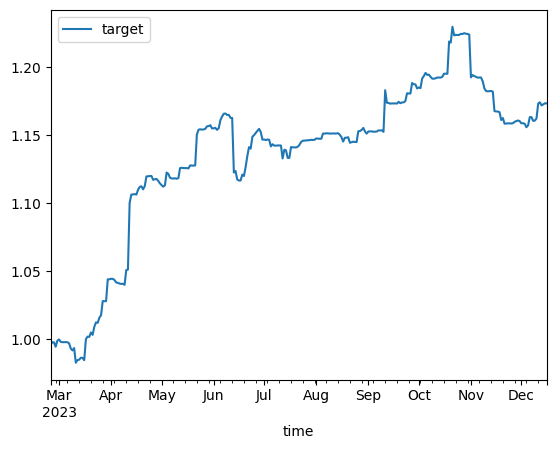

In [21]:
(res.reset_index()[['time','target']].groupby('time').sum()+1).cumprod().plot()

In [22]:
res.reset_index()[['time','target']].groupby('time').sum().mean()/res.reset_index()[['time','target']].groupby('time').sum().std()*np.sqrt(365)

target    2.040904
dtype: float64